## Introduction

The goal of this project is to analyze how different S&P 500 sectors respond to changes in U.S. inflation. By combining financial market data with economic data, this project examines which sectors tend to perform better during inflationary periods and which are more sensitive to inflation.


In [ ]:
# Install required packages (can be skipped if already installed)
!pip install -q yfinance pandas_datareader


# Import libraries
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


### Data Source
ETF price data is loaded from Yahoo Finance via the yfinance library.
CPI inflation data is loaded from the Federal Reserve (FRED) via pandas_datareader.
This ensures data is directly accessible from code without local files.



In [2]:
# S&P 500 sector ETFs
tickers = ['XLK', 'XLE', 'XLF', 'XLP', 'XLU']

# Download monthly adjusted prices
etf_prices = yf.download(
    tickers,
    start='2010-01-01',
    interval='1mo',
    auto_adjust=True,
    progress=False
)['Close']

etf_prices.head()


Ticker,XLE,XLF,XLK,XLP,XLU
Date,,,,,
2010-01-01,16.244593,8.706630,8.471088,17.178885,8.565657
2010-02-01,16.733418,9.013632,8.766124,17.723101,8.452532
2010-03-01,17.144749,9.793423,9.335985,18.313210,8.603365
2010-04-01,17.919659,9.944978,9.483288,18.193258,8.908218
2010-05-01,15.867758,9.034175,8.773764,17.350428,8.416567


In [3]:
# Download CPI data from FRED
cpi = pdr.DataReader('CPIAUCSL', 'fred', start='2010-01-01')
cpi.columns = ['CPI']
cpi.head()


,CPI
DATE,
2010-01-01,217.488
2010-02-01,217.281
2010-03-01,217.353
2010-04-01,217.403
2010-05-01,217.290


## Data Alignment Challenge

A key challenge in combining financial and economic data is ensuring consistent date formats and frequencies.


In [16]:
etf_prices.index = etf_prices.index.to_period('M').to_timestamp()
cpi.index = cpi.index.to_period('M').to_timestamp()
combined_raw = etf_prices.join(cpi, how='inner')



## Data Cleaning and Transformation

Raw price and CPI values cannot be analyzed directly. Prices were converted into monthly returns, and CPI values were converted into monthly inflation rates.


In [5]:
# Monthly sector returns
sector_returns = combined_raw[['XLK', 'XLE', 'XLF', 'XLP', 'XLU']].pct_change()

# Monthly inflation rate
inflation = combined_raw[['CPI']].pct_change()
inflation.columns = ['Inflation']

# Drop missing values
sector_returns = sector_returns.dropna()
inflation = inflation.dropna()

# Combine clean dataset
clean_data = sector_returns.join(inflation, how='inner')
clean_data.head()


,XLK,XLE,XLF,XLP,XLU,Inflation
2010-02-01,0.034829,0.030092,0.035261,0.031679,-0.013207,-0.000952
2010-03-01,0.065007,0.024581,0.086512,0.033296,0.017845,0.000331
2010-04-01,0.015778,0.045198,0.015475,-0.006550,0.035434,0.000230
2010-05-01,-0.074818,-0.114506,-0.091584,-0.046327,-0.055191,-0.000520
2010-06-01,-0.057301,-0.063525,-0.059265,-0.032258,-0.017385,-0.000419


### Why Returns Were Used Instead of Prices

Returns were used instead of price levels because prices across different ETFs are not directly comparable. Percentage returns provide a standardized way to measure performance across sectors.


In [6]:
clean_data.describe()


,XLK,XLE,XLF,XLP,XLU,Inflation
count,188.000000,188.000000,188.000000,188.000000,188.000000,188.000000
mean,0.016362,0.008439,0.011244,0.008685,0.009540,0.002132
std,0.051357,0.078653,0.055028,0.035222,0.042002,0.002613
min,-0.121839,-0.358074,-0.216999,-0.097405,-0.118778,-0.007920
25%,-0.015016,-0.026432,-0.022736,-0.012581,-0.016030,0.000627
50%,0.019535,0.014370,0.019706,0.011461,0.016013,0.002148
75%,0.048823,0.040858,0.044997,0.032585,0.037913,0.003322
max,0.143304,0.336900,0.168483,0.097155,0.097327,0.012952


## Correlation Analysis

Correlation analysis was used to measure the strength and direction of the relationship between sector returns and inflation.


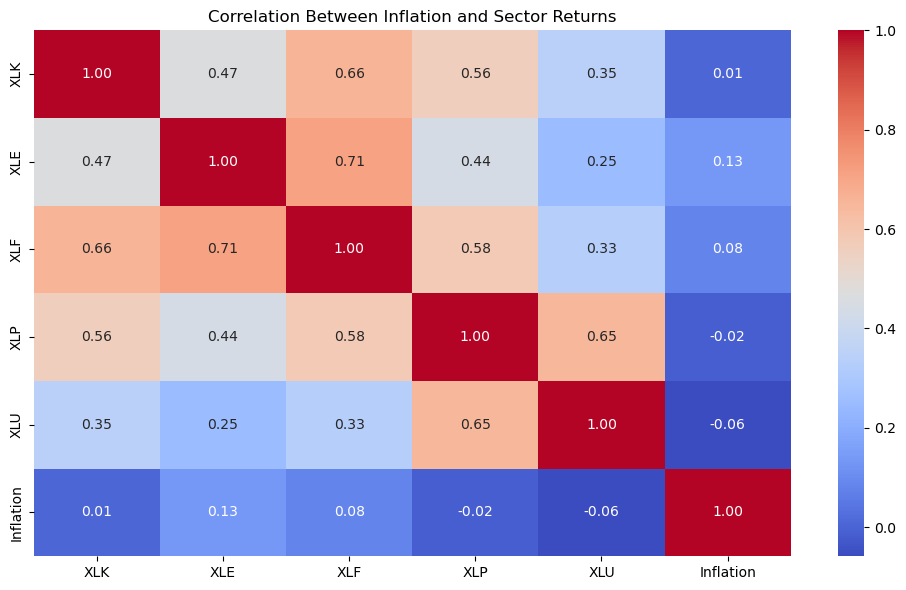

In [7]:
correlation_matrix = clean_data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Inflation and Sector Returns')
plt.tight_layout()
plt.show()


### Sector Sensitivity to Inflation


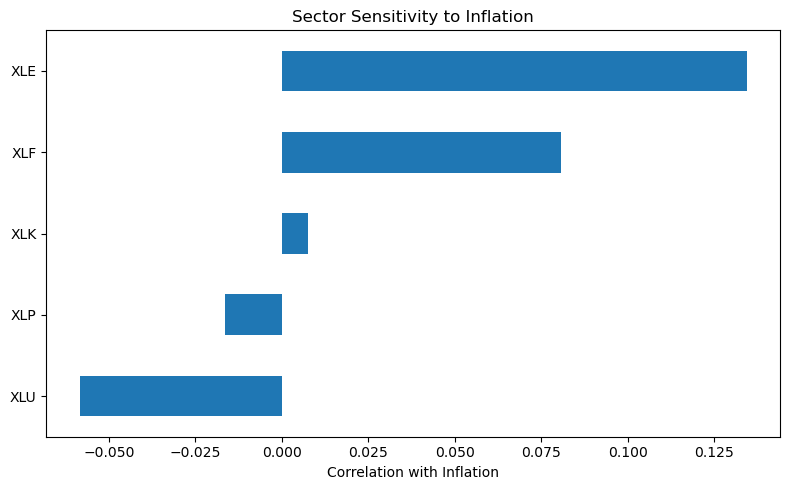

In [8]:
inflation_corr = correlation_matrix['Inflation'].drop('Inflation')

inflation_corr.sort_values().plot(
    kind='barh',
    figsize=(8, 5),
    title='Sector Sensitivity to Inflation'
)
plt.xlabel('Correlation with Inflation')
plt.tight_layout()
plt.show()


## Regression Analysis

Linear regression was used to estimate how changes in inflation affect sector returns.


In [9]:
X = sm.add_constant(clean_data['Inflation'])
y = clean_data['XLE']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    XLE   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.422
Date:                Sun, 14 Dec 2025   Prob (F-statistic):             0.0659
Time:                        16:18:27   Log-Likelihood:                 213.48
No. Observations:                 188   AIC:                            -423.0
Df Residuals:                     186   BIC:                            -416.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.007     -0.026      0.9

In [19]:
results = {}

for sector in ['XLK', 'XLE', 'XLF', 'XLP', 'XLU']:
    X = sm.add_constant(clean_data['Inflation'])
    y = clean_data[sector]
    model = sm.OLS(y, X).fit()

    results[sector] = {
        'Inflation Coefficient': model.params['Inflation'],
        'P-Value': model.pvalues['Inflation'],
        'R-Squared': model.rsquared
    }

regression_results = pd.DataFrame(results).T
regression_results.sort_values(by='Inflation Coefficient', ascending=False)




,Inflation Coefficient,P-Value,R-Squared
XLE,4.046450,0.065915,0.018066
XLF,1.697952,0.271438,0.006499
XLK,0.146316,0.919250,0.000055
XLP,-0.222844,0.821866,0.000273
XLU,-0.938646,0.426095,0.003409


## Aggregation: Average Monthly Returns by Sector

To summarize sector performance over time, the average monthly return for each sector was calculated.



In [17]:
average_monthly_returns = clean_data[['XLK', 'XLE', 'XLF', 'XLP', 'XLU']].mean()
average_monthly_returns


XLK    0.016362
XLE    0.008439
XLF    0.011244
XLP    0.008685
XLU    0.009540
dtype: float64

## Conclusions

The results indicate that S&P 500 sectors respond differently to changes in inflation. Among the sectors analyzed, Energy exhibited the strongest positive relationship with inflation, suggesting relatively higher inflation sensitivity compared to other sectors. Financials showed mild positive sensitivity, while Technology and Utilities demonstrated weaker or negative relationships with inflation.

Overall, inflation alone explains only a small portion of sector return behavior, highlighting the importance of additional macroeconomic factors.



## Limitations

This analysis is based on historical data and does not guarantee future performance. Inflation was measured using CPI, which may not capture all sector-specific price pressures. Additionally, the regression models did not include other macroeconomic variables such as interest rates.


## Reflection

This project strengthened my understanding of how financial and macroeconomic data can be combined to analyze real-world questions. A key takeaway was learning that financial relationships are often noisy and that careful interpretation is required when analyzing market data.

Overall, this project improved my skills in data acquisition, data cleaning, statistical analysis, and communicating results clearly while acknowledging limitations.


## Feature Beyond Course Coverage

This project goes beyond course material by integrating live financial market data and macroeconomic data using external web APIs (Yahoo Finance and FRED). Additionally, the project applies regression analysis to real-world financial data and produces publication-quality visualizations using Seaborn and Matplotlib.
